## Importing the Libraries

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [8]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017_sample.csv') 
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [9]:
df.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)


In [10]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [29]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [30]:
df.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

Here the minority class instances are of the indexes 6,1,4 (the last 3 instances)

### split train set and test set using the sampled set

In [39]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature Engineering

### Feature selection by Information Gain

In [41]:
from sklearn.feature_selection import mutual_info_classif


unique_labels = np.unique(y_train)
print(f"Unique labels in y_train: {unique_labels}")

print(f"Type of labels in y_train: {type(y_train[0])}")

Unique labels in y_train: [0 1 2 3 4 5 6]
Type of labels in y_train: <class 'int'>


In [45]:
if not np.issubdtype(y_train.dtype, np.integer):
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

unique_labels_encoded = np.unique(y_train)
print(f"Unique labels in y_train after encoding: {unique_labels_encoded}")

Unique labels in y_train after encoding: [0 1 2 3 4 5 6]


In [44]:
importances = mutual_info_classif(X_train, y_train)

#### Interpretation
Higher Scores: Features with higher mutual information scores are more informative about the target variable.
Lower Scores: Features with lower scores provide less information about the targetity.

#### Use Case in Feature Selection
Mutual information scores can be used to select a subset of features that are most relevant to the target variable. This can improve model performance by reducing overfitting and computational complexity.

In [46]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [47]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [48]:
X_fs = df[fs].values
##  X_fs_1 is to be checked without using the FCBF Filter
X_fs_1=df[fs].values

In [49]:
X_fs.shape

(56661, 45)

### Feature selection by Fast Correlation Based Filter (FCBF)

This is a Moudule imported from GitHub repo: https://github.com/SantiagoEG/FCBF_module, which is a custom Module

Certain features are redundant because they contain very similar information. FCBF can remove redundant features by calculating the correlation between each pair of features.

In [50]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [51]:
X_fss = fcbf.fit_transform(X_fs,y)

In [52]:
X_fss.shape

(56661, 20)

## Re-split train & test sets after feature selection


This is done including the FCBF Filtering

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [54]:
X_train.shape

(45328, 20)

In [55]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [62]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:10000,4:10000,5:10000,6:10000,1:10000})

In [63]:
unique_classes = np.unique(y_train)
print(f"Unique classes in y_train: {unique_classes}")

Unique classes in y_train: [0 1 2 3 4 5 6]


In [66]:
if not np.issubdtype(y_train.dtype, np.integer):
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)


In [67]:
unique_labels_encoded = np.unique(y_train)
print(f"Unique labels in y_train after encoding: {unique_labels_encoded}")

Unique labels in y_train after encoding: [0 1 2 3 4 5 6]


In [68]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [70]:
importances = mutual_info_classif(X_train, y_train)
print("Mutual Information importances:", importances)

Mutual Information importances: [1.43801035 1.29926797 1.25760732 1.26484108 1.26326475 1.0266708
 1.02693405 0.71105108 1.09598564 1.12107295 1.11995451 1.35098188
 1.35500605 0.65681105 1.27545137 1.41372476 0.94076871 0.9412174
 1.42140594 1.19558333]


In [71]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5    10000
2    10000
6    10000
1    10000
4    10000
Name: count, dtype: int64

## Machine learning model training

### XGBoost with FCBF

Accuracy of XGBoost: 0.9883525986058413
Precision of XGBoost: 0.9893960092289475
Recall of XGBoost: 0.9883525986058413
F1-score of XGBoost: 0.9887471236508235
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4547
           1       0.97      0.99      0.98       393
           2       0.97      1.00      0.98       554
           3       1.00      0.99      1.00      3807
           4       0.25      0.71      0.37         7
           5       0.99      1.00      1.00      1589
           6       0.93      0.98      0.96       436

    accuracy                           0.99     11333
   macro avg       0.87      0.95      0.90     11333
weighted avg       0.99      0.99      0.99     11333



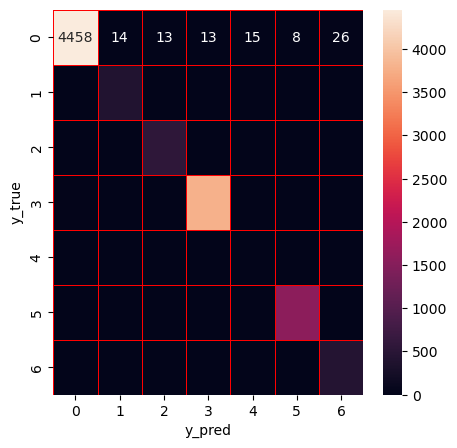

In [72]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [73]:
import hyperopt

In [74]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|█████████████████| 20/20 [00:30<00:00,  1.52s/trial, best loss: -0.9951469160857672]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.19206402419709137, 'max_depth': 12.0, 'n_estimators': 90.0}


Accuracy of XGBoost: 0.9951469160857672
Precision of XGBoost: 0.9954555829079986
Recall of XGBoost: 0.9951469160857672
F1-score of XGBoost: 0.9952605870728645
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.99      0.99       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.42      0.71      0.53         7
           5       1.00      1.00      1.00      1589
           6       0.96      1.00      0.98       436

    accuracy                           1.00     11333
   macro avg       0.91      0.95      0.93     11333
weighted avg       1.00      1.00      1.00     11333



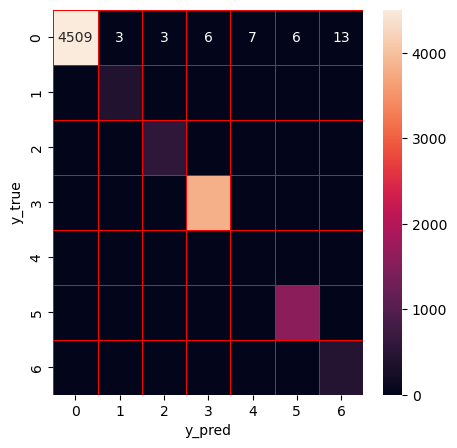

In [75]:
xg = xgb.XGBClassifier(learning_rate= 0.19206402419709137, n_estimators = 90, max_depth = 12)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [76]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### XGBoost without FCBF

In [80]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_fs_1,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

pd.Series(y_train_1).value_counts()




0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
Name: count, dtype: int64

In [82]:
if not np.issubdtype(y_train_1.dtype, np.integer):
    label_encoder = LabelEncoder()
    y_train_1 = label_encoder.fit_transform(y_train_1)
    y_test_1 = label_encoder.transform(y_test_1)

smote=SMOTE(n_jobs=-1,sampling_strategy={2:10000,4:10000,5:10000,6:10000,1:10000})

pd.Series(y_train_1).value_counts()
X_train_1, y_train_1 = smote.fit_resample(X_train_1, y_train_1)

Accuracy of XGBoost: 0.9918821141798289
Precision of XGBoost: 0.991988058951321
Recall of XGBoost: 0.9918821141798289
F1-score of XGBoost: 0.9918832246761021
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.99      0.99       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.42      0.71      0.53         7
           5       1.00      1.00      1.00      1589
           6       0.96      1.00      0.98       436

    accuracy                           1.00     11333
   macro avg       0.91      0.95      0.93     11333
weighted avg       1.00      1.00      1.00     11333



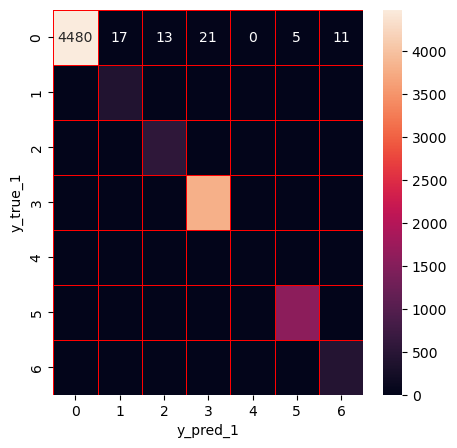

In [83]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train_1,y_train_1)
xg_score=xg.score(X_test_1,y_test_1)
y_predict_1=xg.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred_1")
plt.ylabel("y_true_1")
plt.show()

In [85]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train_1, y_train_1)
    y_pred_1 = clf.predict(X_test_1)
    score = accuracy_score(y_test_1, y_pred_1)

    return {'loss':-score, 'status': STATUS_OK }


space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|█████████████████| 20/20 [00:36<00:00,  1.82s/trial, best loss: -0.9973528633195095]
XGBoost: Hyperopt estimated optimum {'learning_rate': -1.1913956579475435, 'max_depth': 6.0, 'n_estimators': 70.0}


In [ ]:
xg = xgb.XGBClassifier(learning_rate= 0.1206862326628798, n_estimators = 55, max_depth = 75)
xg.fit(X_train_1,y_train_1)
xg_score=xg.score(X_test_1,y_test_1)
y_predict=xg.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true_1,y_predict_1))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [86]:
xg_train_1=xg.predict(X_train_1)
xg_test_1=xg.predict(X_test_1)

### Random Forest

Accuracy of RF: 0.9947057266390188
Precision of RF: 0.9951578876254944
Recall of RF: 0.9947057266390188
F1-score of RF: 0.9948770461006454
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.36      0.71      0.48         7
           5       0.99      1.00      1.00      1589
           6       0.96      0.99      0.98       436

    accuracy                           0.99     11333
   macro avg       0.90      0.95      0.92     11333
weighted avg       1.00      0.99      0.99     11333



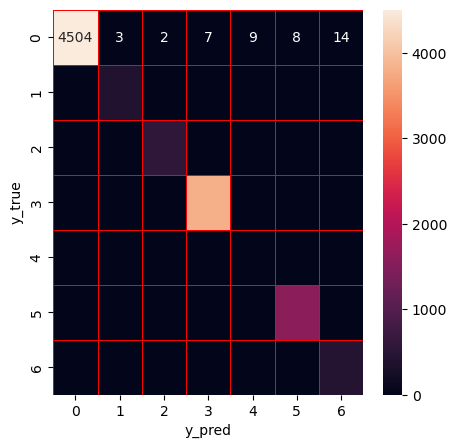

In [87]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [88]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████| 20/20 [04:19<00:00, 12.96s/trial, best loss: -0.99435277508162]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 34.0, 'max_features': 10.0, 'min_samples_leaf': 5.0, 'min_samples_split': 8.0, 'n_estimators': 64.0}


Accuracy of RF: 0.9939998235242213
Precision of RF: 0.9945107944787145
Recall of RF: 0.9939998235242213
F1-score of RF: 0.994205348387386
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.29      0.57      0.38         7
           5       0.99      1.00      1.00      1589
           6       0.95      0.99      0.97       436

    accuracy                           0.99     11333
   macro avg       0.89      0.93      0.90     11333
weighted avg       0.99      0.99      0.99     11333



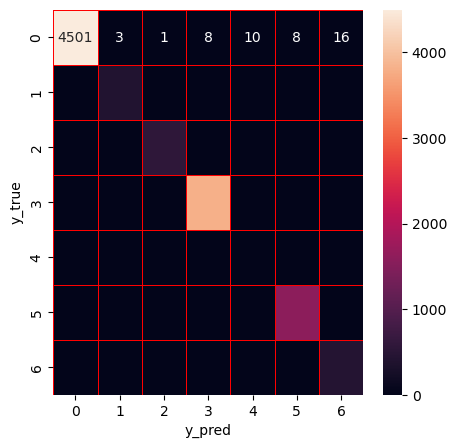

In [89]:
rf_hpo = RandomForestClassifier(n_estimators = 27, min_samples_leaf = 5, max_depth = 34, min_samples_split = 8, max_features = 10, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [90]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Random Forest without FCBF

Accuracy of RF: 0.9948822024177182
Precision of RF: 0.991988058951321
Recall of RF: 0.9918821141798289
F1-score of RF: 0.9918832246761021
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.96      0.99      0.97       393
           2       0.97      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.97      0.99      0.98       436

    accuracy                           0.99     11333
   macro avg       0.98      0.95      0.97     11333
weighted avg       0.99      0.99      0.99     11333



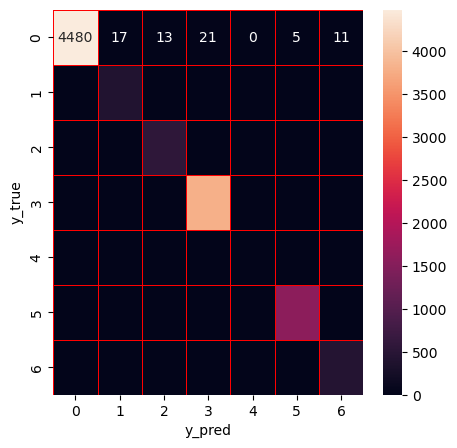

In [91]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train_1,y_train_1) 
rf_score=rf.score(X_test_1,y_test_1)
y_predict=rf.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true_1,y_predict_1))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [92]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train_1,y_train_1)
    score=clf.score(X_test_1,y_test_1)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|█████████████████| 20/20 [12:28<00:00, 37.45s/trial, best loss: -0.9961175328686138]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 27.0, 'max_features': 15.0, 'min_samples_leaf': 4.0, 'min_samples_split': 3.0, 'n_estimators': 120.0}


Accuracy of RF: 0.995499867643166
Precision of RF: 0.995483772917767
Recall of RF: 0.995499867643166
F1-score of RF: 0.9954866874556593
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.97      0.98      0.97       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.67      0.57      0.62         7
           5       1.00      1.00      1.00      1589
           6       0.99      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       0.95      0.93      0.94     11333
weighted avg       1.00      1.00      1.00     11333



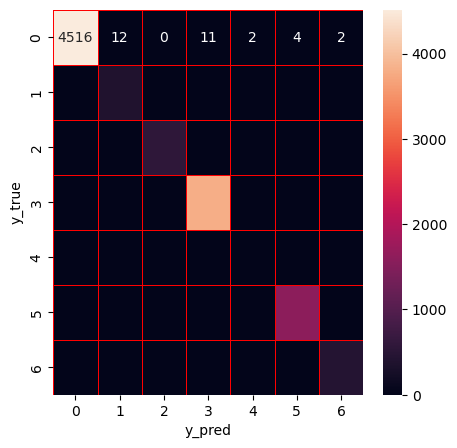

In [93]:
rf_hpo = RandomForestClassifier(n_estimators = 120, min_samples_leaf = 4, max_depth = 27, min_samples_split = 3, max_features = 15, criterion = 'entropy')
rf_hpo.fit(X_train_1,y_train_1)
rf_score=rf_hpo.score(X_test_1,y_test_1)
y_predict_1=rf_hpo.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true_1,y_predict_1))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train_1=rf_hpo.predict(X_train_1)
rf_test_1=rf_hpo.predict(X_test_1)

### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

In [ ]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 4, max_depth = 17, min_samples_split = 8, max_features = 20, criterion = 'entropy')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### DF without FCBF

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train_1,y_train_1) 
dt_score=dt.score(X_test_1,y_test_1)
y_predict_1=dt.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true_1,y_predict_1))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train_1,y_train_1)
    score=clf.score(X_test_1,y_test_1)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

In [ ]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 34, min_samples_split = 9, max_features = 12, criterion = 'entropy')
dt_hpo.fit(X_train_1,y_train_1)
dt_score=dt_hpo.score(X_test_1,y_test_1)
y_predict_1=dt_hpo.predict(X_test_1)
y_true_1=y_test_1
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true_1, y_predict_1, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true_1,y_predict_1))
cm=confusion_matrix(y_true_1,y_predict_1)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train_1=dt_hpo.predict(X_train_1)
dt_test_1=dt_hpo.predict(X_test_1)

### CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# Reshape the data for CNN input (assuming your data is not in image format)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create and compile CNN model
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN model
model_cnn.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_test_cnn, y_test))

# Evaluate CNN model
cnn_score = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print('Accuracy of CNN: ' + str(cnn_score[1]))

# Predict using the model
y_predict_cnn = (model_cnn.predict(X_test_cnn) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score
precision_cnn, recall_cnn, fscore_cnn, _ = precision_recall_fscore_support(y_test, y_predict_cnn, average='weighted')
print('Precision of CNN: ' + str(precision_cnn))
print('Recall of CNN: ' + str(recall_cnn))
print('F1-score of CNN: ' + str(fscore_cnn))

# Print classification report
print(classification_report(y_test, y_predict_cnn))

# Confusion matrix
cm_cnn = confusion_matrix(y_test, y_predict_cnn)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [ ]:
# Define the objective function for CNN
def cnn_objective(params):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=int(params['filters']), kernel_size=int(params['kernel_size']), activation='relu', input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.MaxPooling1D(pool_size=int(params['pool_size'])),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(int(params['dense_units']), activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_cnn, y_train, epochs=int(params['epochs']), validation_data=(X_test_cnn, y_test), verbose=0)
    _, accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter configuration space for CNN
cnn_space = {
    'filters': hp.quniform('filters', 32, 128, 1),
    'kernel_size': hp.quniform('kernel_size', 3, 10, 1),
    'pool_size': hp.quniform('pool_size', 2, 5, 1),
    'dense_units': hp.quniform('dense_units', 32, 128, 1),
    'epochs': hp.quniform('epochs', 5, 20, 1)
}

# Perform hyperparameter optimization for CNN
cnn_trials = Trials()
best_cnn = fmin(fn=cnn_objective, space=cnn_space, algo=tpe.suggest, max_evals=50, trials=cnn_trials)

print("CNN: Hyperopt estimated optimum {}".format(best_cnn))

# Extract the best hyperparameters for CNN
best_filters = int(best_cnn['filters'])
best_kernel_size = int(best_cnn['kernel_size'])
best_pool_size = int(best_cnn['pool_size'])
best_dense_units = int(best_cnn['dense_units'])
best_epochs = int(best_cnn['epochs'])

# Create and train CNN model with best hyperparameters
cnn_hpo = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=best_filters, kernel_size=best_kernel_size, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=best_pool_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(best_dense_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_hpo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_hpo.fit(X_train_cnn, y_train, epochs=best_epochs, validation_data=(X_test_cnn, y_test))

# Evaluate CNN model with best hyperparameters
cnn_score = cnn_hpo.evaluate(X_test_cnn, y_test, verbose=0)
print('Accuracy of CNN with best hyperparameters: ' + str(cnn_score[1]))

# Predict using the CNN model with best hyperparameters
y_predict_cnn = (cnn_hpo.predict(X_test_cnn) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score for CNN model
precision_cnn, recall_cnn, fscore_cnn, _ = precision_recall_fscore_support(y_test, y_predict_cnn, average='weighted')
print('Precision of CNN with best hyperparameters: ' + str(precision_cnn))
print('Recall of CNN with best hyperparameters: ' + str(recall_cnn))
print('F1-score of CNN with best hyperparameters: ' + str(fscore_cnn))

# Print classification report for CNN model
print(classification_report(y_test, y_predict_cnn))

# Confusion matrix for CNN model
cm_cnn = confusion_matrix(y_test, y_predict_cnn)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
cnn_train=cnn_hpo.predict(X_train_cnn)
cnn_test=cnn_hpo.predict(X_test_cnn)

#### CNN without FCBF

In [ ]:
# Reshape the data for CNN input (assuming your data is not in image format)
X_train_cnn_1 = X_train_1.reshape(X_train_1.shape[0], X_train_1.shape[1], 1)
X_test_cnn_1 = X_test_1.reshape(X_test_1.shape[0], X_test_1.shape[1], 1)

# Create and compile CNN model
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn_1.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN model
model_cnn.fit(X_train_cnn_1, y_train_1, epochs=10, validation_data=(X_test_cnn_1, y_test_1))

# Evaluate CNN model
cnn_score = model_cnn.evaluate(X_test_cnn_1, y_test_1, verbose=0)
print('Accuracy of CNN: ' + str(cnn_score[1]))

# Predict using the model
y_predict_cnn_1 = (model_cnn.predict(X_test_cnn_1) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score
precision_cnn, recall_cnn, fscore_cnn, _ = precision_recall_fscore_support(y_test_1, y_predict_cnn_1, average='weighted')
print('Precision of CNN: ' + str(precision_cnn))
print('Recall of CNN: ' + str(recall_cnn))
print('F1-score of CNN: ' + str(fscore_cnn))

# Print classification report
print(classification_report(y_test_1, y_predict_cnn_1))

# Confusion matrix
cm_cnn = confusion_matrix(y_test_1, y_predict_cnn_1)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [ ]:
# Define the objective function for CNN
def cnn_objective(params):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=int(params['filters']), kernel_size=int(params['kernel_size']), activation='relu', input_shape=(X_train_1.shape[1], 1)),
        tf.keras.layers.MaxPooling1D(pool_size=int(params['pool_size'])),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(int(params['dense_units']), activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_cnn_1, y_train_1, epochs=int(params['epochs']), validation_data=(X_test_cnn_1, y_test_1), verbose=0)
    _, accuracy = model.evaluate(X_test_cnn_1, y_test_1, verbose=0)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter configuration space for CNN
cnn_space = {
    'filters': hp.quniform('filters', 32, 128, 1),
    'kernel_size': hp.quniform('kernel_size', 3, 10, 1),
    'pool_size': hp.quniform('pool_size', 2, 5, 1),
    'dense_units': hp.quniform('dense_units', 32, 128, 1),
    'epochs': hp.quniform('epochs', 5, 20, 1)
}

# Perform hyperparameter optimization for CNN
cnn_trials = Trials()
best_cnn = fmin(fn=cnn_objective, space=cnn_space, algo=tpe.suggest, max_evals=50, trials=cnn_trials)

print("CNN: Hyperopt estimated optimum {}".format(best_cnn))

# Extract the best hyperparameters for CNN
best_filters = int(best_cnn['filters'])
best_kernel_size = int(best_cnn['kernel_size'])
best_pool_size = int(best_cnn['pool_size'])
best_dense_units = int(best_cnn['dense_units'])
best_epochs = int(best_cnn['epochs'])

# Create and train CNN model with best hyperparameters
cnn_hpo = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=best_filters, kernel_size=best_kernel_size, activation='relu', input_shape=(X_train_cnn_1.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=best_pool_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(best_dense_units, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_hpo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_hpo.fit(X_train_cnn_1, y_train_1, epochs=best_epochs, validation_data=(X_test_cnn_1, y_test_1))

# Evaluate CNN model with best hyperparameters
cnn_score = cnn_hpo.evaluate(X_test_cnn_1, y_test_1, verbose=0)
print('Accuracy of CNN with best hyperparameters: ' + str(cnn_score[1]))

# Predict using the CNN model with best hyperparameters
y_predict_cnn_1 = (cnn_hpo.predict(X_test_cnn_1) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score for CNN model
precision_cnn, recall_cnn, fscore_cnn, _ = precision_recall_fscore_support(y_test_1, y_predict_cnn_1, average='weighted')
print('Precision of CNN with best hyperparameters: ' + str(precision_cnn))
print('Recall of CNN with best hyperparameters: ' + str(recall_cnn))
print('F1-score of CNN with best hyperparameters: ' + str(fscore_cnn))

# Print classification report for CNN model
print(classification_report(y_test_1, y_predict_cnn_1))

# Confusion matrix for CNN model
cm_cnn = confusion_matrix(y_test_1, y_predict_cnn_1)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
cnn_train_1=cnn_hpo.predict(X_train_cnn_1)
cnn_test_1=cnn_hpo.predict(X_test_cnn_1)

### LSTM

In [ ]:

model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM model
model_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate LSTM model
lstm_score = model_lstm.evaluate(X_test, y_test, verbose=0)
print('Accuracy of LSTM: ' + str(lstm_score[1]))

# Predict using the model
y_predict_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score
precision_lstm, recall_lstm, fscore_lstm, _ = precision_recall_fscore_support(y_test, y_predict_lstm, average='weighted')
print('Precision of LSTM: ' + str(precision_lstm))
print('Recall of LSTM: ' + str(recall_lstm))
print('F1-score of LSTM: ' + str(fscore_lstm))

# Print classification report
print(classification_report(y_test, y_predict_lstm))

# Confusion matrix
cm_lstm = confusion_matrix(y_test, y_predict_lstm)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_lstm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [ ]:
# Define the objective function for LSTM
def lstm_objective(params):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=int(params['units']), input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=int(params['epochs']), validation_data=(X_test, y_test), verbose=0)
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the hyperparameter configuration space for LSTM
lstm_space = {
    'units': hp.quniform('units', 32, 128, 1),
    'epochs': hp.quniform('epochs', 5, 20, 1)
}

# Perform hyperparameter optimization for LSTM
lstm_trials = Trials()
best_lstm = fmin(fn=lstm_objective, space=lstm_space, algo=tpe.suggest, max_evals=50, trials=lstm_trials)

print("LSTM: Hyperopt estimated optimum {}".format(best_lstm))

# Extract the best hyperparameters for LSTM
best_units = int(best_lstm['units'])
best_epochs = int(best_lstm['epochs'])

# Create and train LSTM model with best hyperparameters
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=best_units, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=best_epochs, validation_data=(X_test, y_test))

# Evaluate LSTM model with best hyperparameters
lstm_score = lstm_model.evaluate(X_test, y_test, verbose=0)
print('Accuracy of LSTM with best hyperparameters: ' + str(lstm_score[1]))

# Predict using the LSTM model with best hyperparameters
y_predict_lstm = (lstm_model.predict(X_test) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score for LSTM model
precision_lstm, recall_lstm, fscore_lstm, _ = precision_recall_fscore_support(y_test, y_predict_lstm, average='weighted')
print('Precision of LSTM with best hyperparameters: ' + str(precision_lstm))
print('Recall of LSTM with best hyperparameters: ' + str(recall_lstm))
print('F1-score of LSTM with best hyperparameters: ' + str(fscore_lstm))

# Print classification report for LSTM model
print(classification_report(y_test, y_predict_lstm))

# Confusion matrix for LSTM model
cm_lstm = confusion_matrix(y_test, y_predict_lstm)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_lstm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [ ]:
lstm_train=lstm_model.predict(X_train)
lstm_test=lstm_model.predict(X_test)

#### LSTM without FCBF

In [ ]:

model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM model
model_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate LSTM model
lstm_score = model_lstm.evaluate(X_test, y_test, verbose=0)
print('Accuracy of LSTM: ' + str(lstm_score[1]))

# Predict using the model
y_predict_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")

# Calculate precision, recall, and F1-score
precision_lstm, recall_lstm, fscore_lstm, _ = precision_recall_fscore_support(y_test, y_predict_lstm, average='weighted')
print('Precision of LSTM: ' + str(precision_lstm))
print('Recall of LSTM: ' + str(recall_lstm))
print('F1-score of LSTM: ' + str(fscore_lstm))

# Print classification report
print(classification_report(y_test, y_predict_lstm))

# Confusion matrix
cm_lstm = confusion_matrix(y_test, y_predict_lstm)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_lstm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


### SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(random_state=0)
svm.fit(X_train, y_train)

# Evaluate SVM classifier
svm_score = svm.score(X_test, y_test)
print('Accuracy of SVM: ' + str(svm_score))

# Predict using SVM classifier
y_predict = svm.predict(X_test)
y_true = y_test

# Calculate precision, recall, and F1-score for SVM classifier
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of SVM: ' + str(precision))
print('Recall of SVM: ' + str(recall))
print('F1-score of SVM: ' + str(fscore))

# Print classification report for SVM classifier
print(classification_report(y_true, y_predict))

# Confusion matrix for SVM classifier
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Define the objective function for SVM
def svm_objective(params):
    params = {
        'C': float(params['C']),
        'kernel': str(params['kernel']),
        'gamma': str(params['gamma']) if params['kernel'] == 'rbf' else 'scale',  # gamma only for 'rbf' kernel
        'degree': int(params['degree']) if params['kernel'] == 'poly' else 3,  # degree only for 'poly' kernel
    }
    clf = SVC(**params, random_state=0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return {'loss': -score, 'status': STATUS_OK}

# Define the hyperparameter configuration space for SVM
svm_space = {
    'C': hp.loguniform('C', np.log(1e-6), np.log(1e+3)),
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': hp.choice('gamma', ['scale', 'auto']),
    'degree': hp.quniform('degree', 2, 5, 1)
}

# Perform hyperparameter optimization for SVM
svm_trials = Trials()
best_svm = fmin(fn=svm_objective, space=svm_space, algo=tpe.suggest, max_evals=50, trials=svm_trials)

print("SVM: Hyperopt estimated optimum {}".format(best_svm))

# Extract the best hyperparameters for SVM
best_svm_params = {
    'C': best_svm['C'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'][best_svm['kernel']],
    'gamma': ['scale', 'auto'][best_svm['gamma']],
    'degree': int(best_svm['degree']) if 'degree' in best_svm else 3
}

# Create and train SVM model with best hyperparameters
svm_hpo = SVC(**best_svm_params, random_state=0)
svm_hpo.fit(X_train, y_train)
svm_score = svm_hpo.score(X_test, y_test)
print('Accuracy of SVM with best hyperparameters: ' + str(svm_score))

# Predict using the SVM model with best hyperparameters
y_predict_svm = svm_hpo.predict(X_test)
y_true = y_test

# Calculate precision, recall, and F1-score for SVM model
precision_svm, recall_svm, fscore_svm, _ = precision_recall_fscore_support(y_true, y_predict_svm, average='weighted')
print('Precision of SVM with best hyperparameters: ' + str(precision_svm))
print('Recall of SVM with best hyperparameters: ' + str(recall_svm))
print('F1-score of SVM with best hyperparameters: ' + str(fscore_svm))

# Print classification report for SVM model
print(classification_report(y_true, y_predict_svm))

# Confusion matrix for SVM model
cm_svm = confusion_matrix(y_true, y_predict_svm)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_svm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
svm_train=svm_hpo.predict(X_train)
svm_test=svm_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, CNN, LSTM, XGBoost)

In [ ]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'CNN': cnn_train.ravel(),
    'LSTM': lstm_train.ravel(),
    'SVM':svm_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

In [ ]:
dt_train=dt_train.reshape(-1, 1)
cnn_train=cnn_train.reshape(-1, 1)
lstm_train=lstm_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
svm_train=svm_train.reshape(-1,1)

dt_test=dt_test.reshape(-1, 1)
cnn_test=cnn_test.reshape(-1, 1)
lstm_test=lstm_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
svm_test=svm_test.reshape(-1,1)


In [ ]:
dt_train.shape

In [ ]:
x_train = np.concatenate(( dt_train, cnn_train, lstm_train, rf_train, xg_train, svm_train), axis=1)
x_test = np.concatenate(( dt_test, cnn_test, lstm_test, rf_test, xg_test, svm_test), axis=1)

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [ ]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

In [ ]:
xg = xgb.XGBClassifier(learning_rate= 0.22000784172473817, n_estimators = 35, max_depth = 49)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly Based Detection

### Generate the port-scan datasets for unknown attack detection

In [ ]:
df2=pd.read_csv('./data/CICIDS2017_sample_km.csv')

In [ ]:
df2.Label.value_counts()

In [ ]:
df3 = df2[df2['Label'] != 5]
df3['Label'][df3['Label'] > 0] = 1
df3.to_csv('./data/CICIDS2017_sample_km_without_portscan.csv',index=0)

In [ ]:
df4 = df2[df2['Label'] == 5]
df4['Label'][df4['Label'] == 5] = 1
df4.to_csv('./data/CICIDS2017_sample_km_portscan.csv',index=0)

### Read the generated datasets for unknown attack detection

In [ ]:
df3 = pd.read_csv('./data/CICIDS2017_sample_km_without_portscan.csv')
df4 = pd.read_csv('./data/CICIDS2017_sample_km_portscan.csv')

In [ ]:
features = df3.drop(['Label'],axis=1).dtypes[df3.dtypes != 'object'].index
df3[features] = df3[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df4[features] = df4[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df3 = df3.fillna(0)
df4 = df4.fillna(0)

In [ ]:
df3.Label.value_counts()

In [ ]:
df4.Label.value_counts()

##### Aborting Anomaly Based here due to low sample size for sampled dataset!!!!!!